Libraries imported successfully.
Dataset 'marketing_AB.csv' loaded successfully.
Dataset shape: (588101, 7)


,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


--- Preprocessing Data ---
Data preprocessing complete.


,user id,test group,converted,total ads,most ads day_Monday,most ads day_Tuesday,most ads day_Wednesday,most ads day_Thursday,most ads day_Friday,most ads day_Saturday,...,most ads hour_14,most ads hour_15,most ads hour_16,most ads hour_17,most ads hour_18,most ads hour_19,most ads hour_20,most ads hour_21,most ads hour_22,most ads hour_23
0,1069124,ad,0,130,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,1119715,ad,0,93,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,1144181,ad,0,21,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,1435133,ad,0,355,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1015700,ad,0,276,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False


Features (X), Target (y), and Treatment (T) are defined.
Shape of X: (588101, 32)
Training set size: 470480
Test set size: 117621
--- Training Uplift Models ---
Training Control Model (on PSA data)...
Control model trained.
Training Treatment Model (on Ad data)...
Treatment model trained.
--- Evaluating Model and Calculating Thresholds ---

COPY THESE THRESHOLDS INTO YOUR FLASK 'app.py' FILE:

model_thresholds = {
    'highUplift': 0.0058,
    'lowUplift': -0.0015,
    'highControlProb': 0.0191,
    'negativeUplift': -0.001
}


--- Saving Production Assets ---
Saved feature column list to 'model_assets/feature_columns.joblib'
Saved control model to 'model_assets/control_model.joblib'
Saved treatment model to 'model_assets/treatment_model.joblib'

--- Visualizing Model Performance ---


C:\Users\P RAJ KIRAN\AppData\Local\Temp\ipykernel_15476\888082777.py:166: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  actual_uplift_by_decile = results_df.groupby('decile').apply(


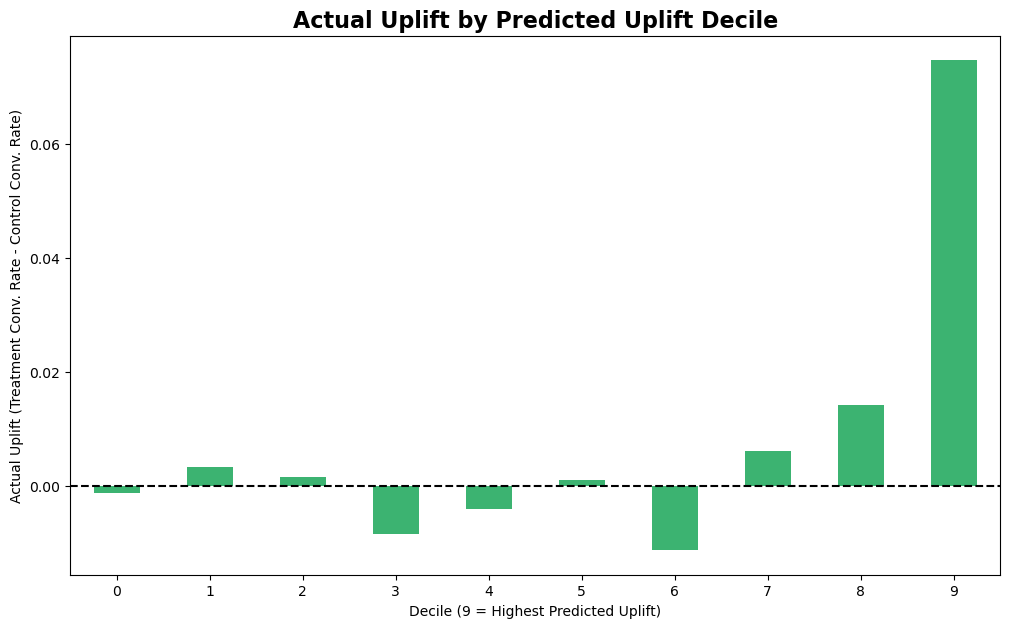


--- Notebook Execution Finished Successfully ---


In [2]:
# -*- coding: utf-8 -*-
"""
==================================================================================
JUPYTER NOTEBOOK FOR UPLIFT MODEL TRAINING
==================================================================================

Purpose: This notebook contains the complete code to train and export the uplift model.
         Running these cells will:
         1.  Load and preprocess the A/B test data from 'marketing_AB.csv'.
         2.  Train the control and treatment RandomForest models.
         3.  Save the two trained models ('control_model.joblib', 'treatment_model.joblib')
             and the feature column list ('feature_columns.joblib') to a
             'model_assets' directory.
         4.  Print the segmentation thresholds needed for the Flask app.

"""
# In[1]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import os
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully.")


# In[2]:
# Step 2: Load the dataset
try:
    df = pd.read_csv('marketing_AB.csv')
    print("Dataset 'marketing_AB.csv' loaded successfully.")
    print("Dataset shape:", df.shape)
    display(df.head())
except FileNotFoundError:
    print("FATAL ERROR: 'marketing_AB.csv' not found. Please ensure the file is in the correct directory.")


# In[3]:
# Step 3: Preprocess the data
print("--- Preprocessing Data ---")

# Drop redundant index column if it exists
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Convert target variable to numeric
df['converted'] = df['converted'].astype(int)

# Use pd.Categorical to ensure all possible values are known for one-hot encoding.
# This prevents errors if a category is missing in a future prediction request.
df['most ads day'] = pd.Categorical(df['most ads day'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df['most ads hour'] = pd.Categorical(df['most ads hour'], categories=list(range(24)), ordered=True)

# Perform one-hot encoding
df_processed = pd.get_dummies(df, columns=['most ads day', 'most ads hour'], drop_first=False)

print("Data preprocessing complete.")
display(df_processed.head())


# In[4]:
# Step 4: Define Features (X), Target (y), and Treatment (T)
y = df_processed['converted']
T = df_processed['test group'].apply(lambda x: 1 if x == 'ad' else 0)
X = df_processed.drop(['user id', 'test group', 'converted'], axis=1)

print("Features (X), Target (y), and Treatment (T) are defined.")
print("Shape of X:", X.shape)


# In[5]:
# Step 5: Split data into training and testing sets
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(
    X, y, T, test_size=0.2, random_state=42, stratify=pd.concat([y, T], axis=1)
)
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


# In[6]:
# Step 6: Train the Uplift Models
print("--- Training Uplift Models ---")

# Separate the training data into control and treatment groups
X_train_control = X_train[T_train == 0]
y_train_control = y_train[T_train == 0]
X_train_treatment = X_train[T_train == 1]
y_train_treatment = y_train[T_train == 1]

# Train Control Model
print("Training Control Model (on PSA data)...")
control_model = RandomForestClassifier(n_estimators=150, random_state=42, max_depth=10, min_samples_leaf=75, n_jobs=-1)
control_model.fit(X_train_control, y_train_control)
print("Control model trained.")

# Train Treatment Model
print("Training Treatment Model (on Ad data)...")
treatment_model = RandomForestClassifier(n_estimators=150, random_state=42, max_depth=10, min_samples_leaf=75, n_jobs=-1)
treatment_model.fit(X_train_treatment, y_train_treatment)
print("Treatment model trained.")


# In[7]:
# Step 7: Evaluate Model and Calculate Thresholds for Production
print("--- Evaluating Model and Calculating Thresholds ---")

# Use the trained models to predict on the test set to find the distribution
prob_control = control_model.predict_proba(X_test)[:, 1]
prob_treatment = treatment_model.predict_proba(X_test)[:, 1]
uplift_scores = prob_treatment - prob_control

# Calculate percentile-based thresholds
high_uplift_threshold = np.percentile(uplift_scores, 80)
low_uplift_threshold = np.percentile(uplift_scores, 20)
high_control_prob_threshold = np.percentile(prob_control, 80)
negative_uplift_threshold = -0.001  # This can be a fixed business rule

print("\nCOPY THESE THRESHOLDS INTO YOUR FLASK 'app.py' FILE:")
print("======================================================")
print(f"""
model_thresholds = {{
    'highUplift': {high_uplift_threshold:.4f},
    'lowUplift': {low_uplift_threshold:.4f},
    'highControlProb': {high_control_prob_threshold:.4f},
    'negativeUplift': {negative_uplift_threshold}
}}
""")
print("======================================================")


# In[8]:
# Step 8: Save Production Assets
print("\n--- Saving Production Assets ---")

# Create a directory to store model assets if it doesn't exist
if not os.path.exists('model_assets'):
    os.makedirs('model_assets')
    print("Created 'model_assets' directory.")

# Save the feature column list to ensure consistency during prediction
joblib.dump(X.columns, 'model_assets/feature_columns.joblib')
print("Saved feature column list to 'model_assets/feature_columns.joblib'")

# Save the trained models
joblib.dump(control_model, 'model_assets/control_model.joblib')
print("Saved control model to 'model_assets/control_model.joblib'")
joblib.dump(treatment_model, 'model_assets/treatment_model.joblib')
print("Saved treatment model to 'model_assets/treatment_model.joblib'")


# In[9]:
# --- Optional: Visualize Uplift Decile Chart ---
print("\n--- Visualizing Model Performance ---")
results_df = pd.DataFrame({
    'uplift_score': uplift_scores,
    'treatment_flag': T_test,
    'converted_flag': y_test
}).sort_values(by='uplift_score', ascending=False)

results_df['decile'] = pd.qcut(results_df['uplift_score'], 10, labels=False, duplicates='drop')

actual_uplift_by_decile = results_df.groupby('decile').apply(
    lambda r: (r[r['treatment_flag'] == 1]['converted_flag'].mean() -
               r[r['treatment_flag'] == 0]['converted_flag'].mean())
)

plt.figure(figsize=(12, 7))
actual_uplift_by_decile.plot(kind='bar', color='mediumseagreen')
plt.title('Actual Uplift by Predicted Uplift Decile', fontsize=16, fontweight='bold')
plt.xlabel('Decile (9 = Highest Predicted Uplift)')
plt.ylabel('Actual Uplift (Treatment Conv. Rate - Control Conv. Rate)')
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=0)
plt.show()

print("\n--- Notebook Execution Finished Successfully ---")

